# An agent for interacting with a SQL database
[LangGraph](https://langchain-ai.github.io/langgraph/tutorials/sql-agent/)

In [1]:
!sudo apt update; sudo apt install sqlite3
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
!pip install langchain-core langchain-community langchain-openai langchainhub langgraph

Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]0m
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]        
Get:4 https://dl.yarnpkg.com/debian stable InRelease [17.1 kB]                 
Get:5 http://deb.debian.org/debian bullseye/main amd64 Packages [8066 kB]      
Get:6 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [339 kB]
Get:7 https://packages.microsoft.com/repos/microsoft-debian-bullseye-prod bullseye InRelease [3650 B]
Get:8 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [18.8 kB]
Get:9 https://dl.yarnpkg.com/debian stable/main all Packages [10.9 kB]33m
Get:10 https://packages.microsoft.com/repos/microsoft-debian-bullseye-prod bullseye/main all Packages [1444 B]
Get:11 https://packages.microsoft.com/repos/microsoft-debian-bullseye-prod bullseye/main amd64 Packages [186 kB]
Get:12 https://dl.yarnpkg.com/debian sta

In [28]:
import os
import hashlib
import re
import ast

from dotenv import load_dotenv
from typing import Any, Annotated, Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display
from uuid import uuid4

from langchain import hub
from langchain.agents.agent_toolkits import create_retriever_tool
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.messages import ToolMessage, AIMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

from langsmith.evaluation import evaluate

_ = load_dotenv()

In [8]:
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

# # Check ids and replace it with null
# def remove_message_ids(messages):
#     for msg in messages:
#         if 'tool_calls' in msg.additional_kwargs.keys():
#             for tool in  msg.additional_kwargs['tool_calls']:
#                 tool['id'] = ''
        
#         msg.id = ''

#         if getattr(msg, 'tool_calls', None):
#             for tool in msg.tool_calls:
#                 tool['id'] = ''

#     return messages

# # Function to generate cache key
# def generate_cache_key(messages):
#     """Generate a unique key for the given input"""
#     input_text = "".join(str(msg) for msg in remove_message_ids(messages))
#     return hashlib.md5(input_text.encode()).hexdigest()

# # Get value from cache and generate ids be null
# def gen_message_ids_from_cache(cache_type, key):
#     messages = cache_state[cache_type][key]
#     for msg in messages:
#         if 'tool_calls' in msg.additional_kwargs.keys():
#             for tool in  msg.additional_kwargs['tool_calls']:
#                 tool['id'] = str(uuid4())
        
#         msg.id = str(uuid4())

#         if getattr(msg, 'tool_calls', None):
#             for tool in msg.tool_calls:
#                 tool['id'] = str(uuid4())
    
#     return messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# class CacheState(TypedDict):
#     get_schema_cache: dict[str, Any]
#     check_query_cache: dict[str, Any]
#     gen_query_cache: dict[str, Any]

# cache_state = CacheState({"get_schema_cache": {}, "check_query_cache": {}, "gen_query_cache": {}})

In [9]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
DIALECT = db.dialect
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

toolkit = SQLDatabaseToolkit(db=db, llm=AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("Artist"))

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [4]:
# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {"messages": [AIMessage(content="", tool_calls=[{
                "name": "sql_db_list_tables", "args": {}, "id": str(uuid4())
            }])]}


schema_get_system = f"""Given an input question to {DIALECT} and a list of tables. You will choose tables that are relevant to the question, after that you will call the 'get_schema_tool' tool.

Your output can only be a tool call of 'get_schema_tool'.
"""

schema_get_prompt = ChatPromptTemplate.from_messages(
    [("system", schema_get_system), ("placeholder", "{messages}")]
)

# Add a node for a model to choose the relevant tables based on the question and available tables
schema_get = schema_get_prompt | AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0).bind_tools(
    [get_schema_tool], tool_choice="required"
)

def model_get_schema(state: State):
    # cache_key = generate_cache_key(state["messages"].copy())
    # if cache_key in cache_state["get_schema_cache"]:
    #     print("Using cached schema")
    #     return gen_message_ids_from_cache("get_schema_cache", cache_key)
    # else:
    #     result = schema_get.invoke(state["messages"])
    #     cache_state["get_schema_cache"][cache_key] = remove_message_ids([result])
    #     return {"messages": [result]}
    return {"messages": [schema_get.invoke({"messages": state["messages"]})]}

In [5]:
@tool
def sql_db_query(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Warning: Empty result. You should try to rewrite the query to get a non-empty result set."
    return result

print(sql_db_query.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [6]:
NUM_TRY = 2

# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

# Add a node for a model to generate a query based on the question and schema
guide_system = f"""Given an input question to {DIALECT}, and schemas of relevant tables. You will do one of the following jobs:
- If the most recent message is database schemas, you should output a syntactically correct {DIALECT} query for the question.
- If you are given a query error from the database, correct the wrong {DIALECT} query.
- If you are given a result of the right query and have enough information to answer the input question, call the SubmitFinalAnswer to answer the question with the information you have for the user.
"""

query_gen_system = f"""
Rules for a query:
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most five results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
- Answer the user after {NUM_TRY} times of try, the answer can be a true result from database running or an error.

DO NOT:
- NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", guide_system + query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0).bind_tools(
    [sql_db_query, SubmitFinalAnswer], tool_choice="required"
)

def model_gen_query(state: State):
    return {"messages": [query_gen.invoke({"messages": state["messages"]})]}

In [7]:
def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))

artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
genres = query_as_list(db, "SELECT Name FROM Genre")

embeddings = AzureOpenAIEmbeddings(
    model='text-embedding-3-large',
    azure_endpoint=os.getenv("AZURE_OPENAI_EMB_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_EMB_API_KEY"),
    openai_api_version="2023-05-15"
)
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_texts(artists + albums + genres)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)

noun_retrieve_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

# Add to system message
noun_retrieve_system = f"""Given an input question to {DIALECT}. You will check whether there are any proper nouns in the question.

If the question requires filtering on a proper noun like a Name, you must ALWAYS first look up the filter value using the 'search_proper_nouns' tool! Do not try to guess at the proper name - use this function to find similar ones.

In contrast, if the given question does not require filtering on a proper noun, you will generate a syntactically correct {DIALECT} query for the question based schemas of relevant tables.

Your output can only be a tool call of 'search_proper_nouns' or 'sql_db_query'."""

noun_retrieve_prompt = ChatPromptTemplate.from_messages(
    [("system", noun_retrieve_system), ("placeholder", "{messages}")]
)
noun_retrieve = noun_retrieve_prompt | AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-16k",
    openai_api_version="2024-08-01-preview",
    temperature=0).bind_tools(
    [noun_retrieve_tool, sql_db_query]
)

def model_retrieve_noun(state: State) -> dict[str, list[AIMessage]]:
    return {"messages": [noun_retrieve.invoke({"messages": state["messages"]})]}

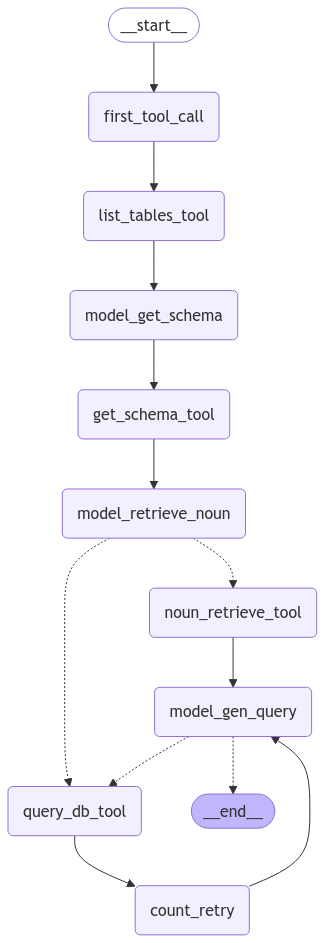

In [ ]:
def count_retry(state: State):
    count = 0
    for mess in state["messages"]:
        if getattr(mess, "tool_calls", None):
            if mess.tool_calls[0]["name"] == "sql_db_query":
                count += 1
    
    if count == 2:
        return {"messages": [HumanMessage(content=f"You have reached {count} times of try. Please call the SubmitFinalAnswer tool!")]}

workflow = StateGraph(State)

workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("model_get_schema", model_get_schema)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
workflow.add_node("model_retrieve_noun", model_retrieve_noun)
workflow.add_node("noun_retrieve_tool", create_tool_node_with_fallback([noun_retrieve_tool]))
workflow.add_node("model_gen_query", model_gen_query)
workflow.add_node("query_db_tool", create_tool_node_with_fallback([sql_db_query]))
workflow.add_node("count_retry", count_retry)

workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "model_retrieve_noun")

def have_proper_noun(state: State) -> Literal["noun_retrieve_tool", "query_db_tool"]:
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        if last_message.tool_calls[0]["name"] == "search_proper_nouns":
            return "noun_retrieve_tool"
        if last_message.tool_calls[0]["name"] == "sql_db_query":
            return "query_db_tool"

workflow.add_conditional_edges("model_retrieve_noun", have_proper_noun)
workflow.add_edge("noun_retrieve_tool", "model_gen_query")

# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "query_db_tool"]:
    messages = state["messages"]
    last_message = messages[-1]
            
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        if last_message.tool_calls[0]["name"] == "SubmitFinalAnswer":
            return END
        if last_message.tool_calls[0]["name"] == "sql_db_query":
            return "query_db_tool"

workflow.add_conditional_edges("model_gen_query", should_continue)
workflow.add_edge("query_db_tool", "count_retry")
workflow.add_edge("count_retry", "model_gen_query")

# Compile the workflow into a runnable
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [40]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

class SQL_Bot:
    def __init__(self, db=None, num_try=2):
        if db == None:
            self.db = SQLDatabase.from_uri("sqlite:///Chinook.db")
            self.dialect = self.db.dialect
        else:
            self.db = db

        self.num_try = num_try

        # Setup tools
        toolkit = SQLDatabaseToolkit(db=self.db, llm=AzureChatOpenAI(
            azure_deployment="gpt-35-turbo-16k",
            openai_api_version="2024-08-01-preview",
            temperature=0))
        tools = toolkit.get_tools()

        self.list_tables_tool = next(t for t in tools if t.name == "sql_db_list_tables")
        self.get_schema_tool = next(t for t in tools if t.name == "sql_db_schema")
        self.query_db_tool = tool("sql_db_query", self.query_db_func)

        description = "Use to look up values to filter on. Input is an approximate spelling of the proper noun, output is valid proper nouns. Use the noun most similar to the search."
        self.retrieve_noun_tool = create_retriever_tool(self.create_proper_noun_retriever(), name="sql_db_retrieve_proper_nouns", description=description)

        # Chain that is for a model to choose the relevant tables based on the question and available tables
        schema_get_system = f"""Given an input question to {self.dialect} and a list of tables. You will choose tables that are relevant to the question, after that you will call the 'sql_db_schema' tool.
        Your output can only be a tool call of 'sql_db_schema'.
        """

        self.schema_get = ChatPromptTemplate.from_messages(
                [("system", schema_get_system), ("placeholder", "{messages}")]
            ) | AzureChatOpenAI(
                azure_deployment="gpt-35-turbo-16k",
                openai_api_version="2024-08-01-preview",
                temperature=0).bind_tools(
                [self.get_schema_tool], tool_choice="required"
            )

        # Chain that is for a model to make decision wheather to have a proper noun in the question and use search tool for finding the exact noun
        noun_retrieve_system = f"""Given an input question to {self.dialect}. You will check whether there are any proper nouns in the question:
        - If the question requires filtering on a proper noun like a Name, you must ALWAYS first look up the filter value using the 'sql_db_retrieve_proper_nouns' tool! Do not try to guess at the proper name - use this function to find similar ones.
        - In contrast, if the question does not require filtering on a proper noun, you will generate a syntactically correct {self.dialect} query for the question based schemas of relevant tables using the 'sql_db_query' tool.

        Your output can only be a tool call of 'sql_db_retrieve_proper_nouns' or 'sql_db_query'."""

        self.noun_retrieve = ChatPromptTemplate.from_messages(
                [("system", noun_retrieve_system), ("placeholder", "{messages}")]
            ) | AzureChatOpenAI(
                azure_deployment="gpt-35-turbo-16k",
                openai_api_version="2024-08-01-preview",
                temperature=0).bind_tools(
                [self.retrieve_noun_tool, self.query_db_tool], tool_choice="required"
            )

        # Chain that is for a model to generate a query based on the question and schemas
        query_gen_system = f"""Given an input question to {self.dialect}, and schemas of relevant tables. You will do one of the following jobs:
        - If the most recent message is database schemas, you should output a syntactically correct {self.dialect} query for the question.
        - If you are given a query error from the database, correct the wrong {self.dialect} query.
        - If you are given a result of the right query and have enough information to answer the input question, call the SubmitFinalAnswer to answer the question with the information you have for the user.

        Rules for a query:
        - Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most five results.
        - You can order the results by a relevant column to return the most interesting examples in the database.
        - Never query for all the columns from a specific table, only ask for the relevant columns given the question.
        - If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
        - Answer the user after {self.num_try} times of try, the answer can be a true result from database running or an error.

        DO NOT:
        - NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.
        - DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
        """

        self.query_gen = ChatPromptTemplate.from_messages(
                [("system", query_gen_system), ("placeholder", "{messages}")]
            ) | AzureChatOpenAI(
                azure_deployment="gpt-35-turbo-16k",
                openai_api_version="2024-08-01-preview",
                temperature=0).bind_tools(
                [self.query_db_tool, self.SubmitFinalAnswer], tool_choice="required"
            )

        # Define a graph
        graph = StateGraph(State)
        graph.add_node("first_tool_call", self.first_tool_call)
        graph.add_node("list_tables_tool", create_tool_node_with_fallback([self.list_tables_tool]))
        graph.add_node("model_get_schema", self.model_get_schema)
        graph.add_node("get_schema_tool", create_tool_node_with_fallback([self.get_schema_tool]))
        graph.add_node("model_retrieve_noun", self.model_retrieve_noun)
        graph.add_node("retrieve_noun_tool", create_tool_node_with_fallback([self.retrieve_noun_tool]))
        graph.add_node("model_gen_query", self.model_gen_query)
        graph.add_node("query_db_tool", create_tool_node_with_fallback([self.query_db_tool]))
        graph.add_node("count_retry_call", self.count_retry_call)

        graph.add_edge(START, "first_tool_call")
        graph.add_edge("first_tool_call", "list_tables_tool")
        graph.add_edge("list_tables_tool", "model_get_schema")
        graph.add_edge("model_get_schema", "get_schema_tool")
        graph.add_edge("get_schema_tool", "model_retrieve_noun")
        graph.add_conditional_edges("model_retrieve_noun", self.have_proper_noun)
        graph.add_edge("retrieve_noun_tool", "model_gen_query")
        graph.add_conditional_edges("model_gen_query", self.should_continue)
        graph.add_edge("query_db_tool", "count_retry_call")
        graph.add_edge("count_retry_call", "model_gen_query")

        # Compile the graph into a runnable
        memory = MemorySaver()
        self.graph = graph.compile(checkpointer=memory)

    # Retriever to retrieve proper nouns for high-cardinality
    def create_proper_noun_retriever(self):
        def query_as_list(db, query):
            res = db.run(query)
            res = [el for sub in ast.literal_eval(res) for el in sub if el]
            res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
            return list(set(res))

        artists = query_as_list(self.db, "SELECT Name FROM Artist")
        albums = query_as_list(self.db, "SELECT Title FROM Album")
        genres = query_as_list(self.db, "SELECT Name FROM Genre")

        embeddings = AzureOpenAIEmbeddings(
            model='text-embedding-3-large',
            azure_endpoint=os.getenv("AZURE_OPENAI_EMB_ENDPOINT"),
            api_key=os.getenv("AZURE_OPENAI_EMB_API_KEY"),
            openai_api_version="2023-05-15"
        )

        vector_store = InMemoryVectorStore(embeddings)
        _ = vector_store.add_texts(artists + albums + genres)
        return vector_store.as_retriever(search_kwargs={"k": 5})

    # Setup custom query tool
    def query_db_func(self, query: str) -> str:
        """
        Execute a SQL query against the database and get back the result.
        If the query is not correct, an error message will be returned.
        If an error is returned, rewrite the query, check the query, and try again.
        """
        result = self.db.run_no_throw(query)
        if not result:
            return "Warning: Empty result. You should try to rewrite the query to get a non-empty result set."
        return result

    # Setup custom tool to represent the end state
    class SubmitFinalAnswer(BaseModel):
        """Submit the final answer to the user based on the query results."""
        final_answer: str = Field(..., description="The final answer to the user")

    def first_tool_call(self, state: State) -> dict[str, list[AIMessage]]:
        return {"messages": [AIMessage(content="", tool_calls=[{
                    "name": "sql_db_list_tables", "args": {}, "id": str(uuid4())
                }])]}

    def model_get_schema(self, state: State):
        return {"messages": [self.schema_get.invoke({"messages": state["messages"]})]}
    
    def model_retrieve_noun(self, state: State) -> dict[str, list[AIMessage]]:
        return {"messages": [self.noun_retrieve.invoke({"messages": state["messages"]})]}

    def have_proper_noun(self, state: State) -> Literal["retrieve_noun_tool", "query_db_tool"]:
        messages = state["messages"]
        last_message = messages[-1]
        if getattr(last_message, "tool_calls", None):
            if last_message.tool_calls[0]["name"] == "sql_db_retrieve_proper_nouns":
                return "retrieve_noun_tool"
            if last_message.tool_calls[0]["name"] == "sql_db_query":
                return "query_db_tool"
            
    def model_gen_query(self, state: State):
        return {"messages": [self.query_gen.invoke({"messages": state["messages"]})]}
    
    # Define a conditional edge to decide whether to continue or end the workflow
    def should_continue(self, state: State) -> Literal[END, "query_db_tool"]:
        messages = state["messages"]
        last_message = messages[-1]
                
        # If there is a tool call, then we finish
        if getattr(last_message, "tool_calls", None):
            if last_message.tool_calls[0]["name"] == "SubmitFinalAnswer":
                return END
            if last_message.tool_calls[0]["name"] == "sql_db_query":
                return "query_db_tool"
        
    def count_retry_call(self, state: State):
        count = 0
        for mess in state["messages"]:
            if getattr(mess, "tool_calls", None):
                if mess.tool_calls[0]["name"] == "sql_db_query":
                    count += 1
        
        if count == 2:
            return {"messages": [HumanMessage(content=f"You have reached {count} times of try. Please call the SubmitFinalAnswer tool!")]}
        
    def show_graph(self):
        display(Image(self.graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

bot = SQL_Bot()

In [ ]:
questions = ["How many employees are there?",
             "Which country/'s customers spent the most?",
             "Describe the playlisttrack table",
             "How many albums does alis in chain have?",
             "Which sales agent made the most in sales in 2009?",
             "What was the most purchased track of 2013?",
             "How many albums does the artist Led Zeppelin have?",
             "What is the total price for the album “Big Ones”?"]
answers = [8,
           ('USA', 523.06),
           'PlaylistTrack',
           1,
           'Steve Johnson',
           'Hot Girl',
           14,
           14.85]
threads = [{"configurable": {"thread_id": "0"}},
           {"configurable": {"thread_id": "1"}},
           {"configurable": {"thread_id": "2"}},
           {"configurable": {"thread_id": "3"}},
           {"configurable": {"thread_id": "4"}},
           {"configurable": {"thread_id": "5"}},
           {"configurable": {"thread_id": "6"}},
           {"configurable": {"thread_id": "7"}}]
inp_state = {"messages": [("user", questions[7])]}
stream = bot.graph.stream(inp_state, threads[7])
conn = ''
while conn == '':
    try:
        print(next(stream))
    except StopIteration:
        break
    conn = input('Enter for continue')

{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='cf0efe34-ee4c-4a43-b82f-31c46b59442d', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'dd9ee103-80d5-4204-8ecc-f52c15d098e5', 'type': 'tool_call'}])]}}


{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='39d3bdac-aa2e-43aa-baf7-75041bd6bfca', tool_call_id='dd9ee103-80d5-4204-8ecc-f52c15d098e5')]}}
{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BPKuY8vakNtXLQzbJ5LBihGk', 'function': {'arguments': '{\n  "table_names": "Album, Track, InvoiceLine"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 228, 'total_tokens': 248, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'

In [ ]:
questions = ["How many employees are there?",
             "Which country/'s customers spent the most?",
             "Describe the playlisttrack table",
             "How many albums does alis in chain have?",
             "Which sales agent made the most in sales in 2009?",
             "What was the most purchased track of 2013?",
             "How many albums does the artist Led Zeppelin have?",
             "What is the total price for the album “Big Ones”?"]
answers = [8,
           ('USA', 523.06),
           'PlaylistTrack',
           1,
           'Steve Johnson',
           'Hot Girl',
           14,
           14.85]
threads = [{"configurable": {"thread_id": "0"}},
           {"configurable": {"thread_id": "1"}},
           {"configurable": {"thread_id": "2"}},
           {"configurable": {"thread_id": "3"}},
           {"configurable": {"thread_id": "4"}},
           {"configurable": {"thread_id": "5"}},
           {"configurable": {"thread_id": "6"}},
           {"configurable": {"thread_id": "7"}}]
inp_state = {"messages": [("user", questions[7])]}
stream = app.stream(inp_state, threads[7])
conn = ''
while conn == '':
    try:
        print(next(stream))
    except StopIteration:
        break
    conn = input('Enter for continue')

{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='4b9120e4-2d2d-4b94-986a-58286f83425b', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '546a5c15-43a2-4ee4-9e7a-b845aa2c35d8', 'type': 'tool_call'}])]}}


{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='fbc8943e-4b5a-4369-8987-ebb8d2ad4d3c', tool_call_id='546a5c15-43a2-4ee4-9e7a-b845aa2c35d8')]}}
{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Klyh1JB7V0zOvFzJoVbRUUdU', 'function': {'arguments': '{\n  "table_names": "Album, Invoice, InvoiceLine, Track"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 227, 'total_tokens': 249, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-35-turbo-16k', 'system_fingerprint': 'fp_0165350fbb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_

In [159]:
app.get_state(threads[0]).values['messages']

[HumanMessage(content='How many employees are there?', additional_kwargs={}, response_metadata={}, id='e6737775-36fc-4ca2-a178-153847820835'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='d4a995a0-454c-47cd-8c39-63ff85e3c938', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'ff087ed9-c5a9-433e-ada9-1c430a0172db', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='29a1b522-0874-4bb8-b5b7-1b81fe1672b0', tool_call_id='ff087ed9-c5a9-433e-ada9-1c430a0172db'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_L8E3eJjYUh7Wjin7MWwUo0Gf', 'function': {'arguments': '{"table_names": "Employee"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 1542, 'total_tokens': 1554, 'completion_tokens_details': None, 'prompt_

In [161]:
app.get_state(threads[1]).values['messages']

[HumanMessage(content="Which country/'s customers spent the most?", additional_kwargs={}, response_metadata={}, id='053d4999-5f7a-4459-b595-a41e9bf23b00'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='50c69fbc-cb68-4f0a-a96e-c2b6734e25ab', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '547e2898-5c9e-4bf3-a941-171f90819187', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='2af773ff-cfbd-487e-a1cd-b6eeaf230914', tool_call_id='547e2898-5c9e-4bf3-a941-171f90819187'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_koP29jFExuVU9uHS1Z6ixnqx', 'function': {'arguments': '{\n  "table_names": "Invoice, Customer"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 173, 'total_tokens': 190, 'completion_token

In [163]:
app.get_state(threads[2]).values['messages']

[HumanMessage(content='Describe the playlisttrack table', additional_kwargs={}, response_metadata={}, id='4fe22477-929a-4c7e-aa36-72db863c8d15'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='29af5191-52e2-4013-89b0-5f8c6a0ce978', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '6e20f483-6c12-4056-9d7c-760db9803141', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='d4d85e51-46c9-4825-aaac-b5d9922ffbe6', tool_call_id='6e20f483-6c12-4056-9d7c-760db9803141'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BbWvUUeSMQGBEtamYQjDR9hF', 'function': {'arguments': '{\n  "table_names": "PlaylistTrack"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 169, 'total_tokens': 185, 'completion_tokens_details': No

In [10]:
app.get_state(threads[3]).values['messages']

[HumanMessage(content='How many albums does alis in chain have?', additional_kwargs={}, response_metadata={}, id='33b82956-7c01-4529-beed-0226ab7fd613'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='cb7bced6-412d-4958-996f-c26a5b47961b', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'aee713dc-eeae-49ea-9b7e-43a7e463af92', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='e3365f9a-fa76-43e7-9ac1-4079e7c501b0', tool_call_id='aee713dc-eeae-49ea-9b7e-43a7e463af92'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UD00sN6E7t0PZqYAaFrBTM4P', 'function': {'arguments': '{\n  "table_names": "Album, Artist"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 225, 'total_tokens': 242, 'completion_tokens_deta

In [12]:
# The last question has failed with a null result, bad query
db.run("SELECT e.FirstName, e.LastName, SUM(il.UnitPrice * il.Quantity) AS TotalSales FROM Employee e JOIN Invoice i ON e.EmployeeId = i.CustomerId JOIN InvoiceLine il ON i.InvoiceId = il.InvoiceId WHERE strftime(\'%Y\', i.InvoiceDate) = \'2009\' GROUP BY e.EmployeeId ORDER BY TotalSales DESC LIMIT 1")

app.get_state(threads[4]).values['messages']

[HumanMessage(content='Which sales agent made the most in sales in 2009?', additional_kwargs={}, response_metadata={}, id='4ef3bfea-8fc3-4518-b623-a67b64d8fdc7'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='058f99b1-0e31-48b9-86bc-9d7d798e28b0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'f124583a-6d39-431e-b328-72b7d0052595', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='871bc5d8-964f-45f0-b340-aaa2b1b7ec4e', tool_call_id='f124583a-6d39-431e-b328-72b7d0052595'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bYXb1CmBOSkSO8sJNMIYG6It', 'function': {'arguments': '{\n  "table_names": "Employee, Invoice, InvoiceLine"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 228, 'total_tokens': 24

In [14]:
app.get_state(threads[5]).values['messages']

[HumanMessage(content='What was the most purchased track of 2013?', additional_kwargs={}, response_metadata={}, id='14e1531b-191f-47d8-9740-ae92cb8faaf1'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='b7393781-b282-4068-a543-69e626337803', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '30b155c7-fe99-40de-9ee0-f44e74f23071', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='161fee47-eece-41ca-932c-8ca035eeadb9', tool_call_id='30b155c7-fe99-40de-9ee0-f44e74f23071'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Fa5h9NFAM1zugToWLiB6HeIK', 'function': {'arguments': '{\n  "table_names": "Track, InvoiceLine"\n}', 'name': 'get_schema_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 226, 'total_tokens': 244, 'completion_to

In [14]:
app.get_state(threads[6]).values['messages']

[HumanMessage(content='How many albums does the artist Led Zeppelin have?', additional_kwargs={}, response_metadata={}, id='c5714aed-2f32-4a95-b033-751c1c12b1b0'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='64cc46f3-5bb8-48ea-a91f-333e86b80b9c', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'de252134-3286-423e-b9f4-2badb4242c05', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='422a2b49-4ba4-431e-8e13-e5b91afe1879', tool_call_id='de252134-3286-423e-b9f4-2badb4242c05'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kA5UzH4SoNeaFWSP87oHAL0J', 'function': {'arguments': '{\n  "table_names": "Album"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 175, 'total_tokens': 190, 'completion_tokens_de

In [15]:
app.get_state(threads[7]).values['messages']

[HumanMessage(content='What is the total price for the album “Big Ones”?', additional_kwargs={}, response_metadata={}, id='ff87536b-a3cd-4235-af71-e9dff4ca8f91'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='2109ae3a-0caf-4c5e-91c1-97522a06542c', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': '7521e7b2-de32-4717-8502-a0c84c4bbf80', 'type': 'tool_call'}]),
 ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='a271fdaf-fc5a-402c-9870-31c9eb16dd2d', tool_call_id='7521e7b2-de32-4717-8502-a0c84c4bbf80'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eGKdCwIha36NBJsFO2b78uEb', 'function': {'arguments': '{\n  "table_names": "Album"\n}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 176, 'total_tokens': 191, 'completion_tokens_det

In [26]:
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = app.invoke(msg)
    json_str = messages["messages"][-1].tool_calls[0]["args"]
    response = json_str["final_answer"]
    return {"response": response}

# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, chain
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # LLM grader
    llm = AzureChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

print(grade_prompt_answer_accuracy.messages[0].prompt.template)

You are a teacher grading a quiz. 

You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER. 

Here is the grade criteria to follow:
(1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer. 
(2) Ensure that the student answer does not contain any conflicting statements.
(3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.

Score:
A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 
A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset.


In [30]:
dataset_name = "SQL Agent Response"
experiment_results = evaluate(
    predict_sql_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    num_repetitions=3,
    experiment_prefix="sql-agent-multi-step-response-v-reference",
    metadata={"version": "Chinook, gpt-4o multi-step-agent"},
)